This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [1]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [2]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

In [3]:
# Need to load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Look at all of the available columns
df.head(1)

,Date_,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,2020-01-22,NaN,NaN,Anhui,Mainland China,1/22/2020 17:00,NaN,NaN,1.0,NaN,NaN,NaN,NaN


The "data date" is 2020-05-19 00:00:00

ADF Statistic: -1.383667
p-value: 0.590081
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


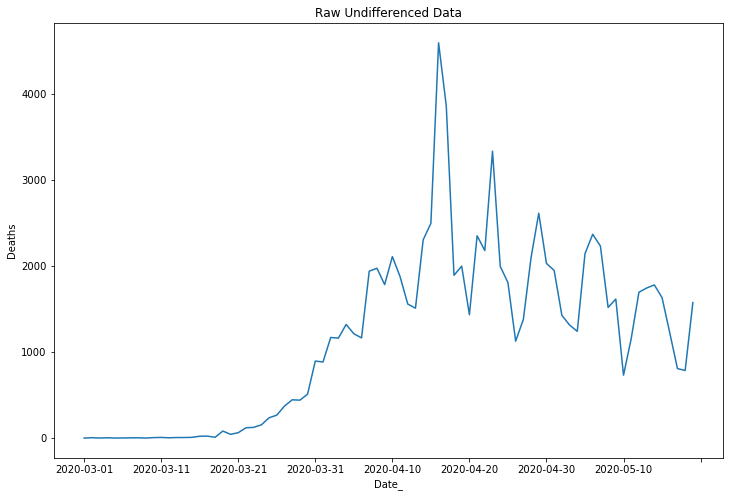

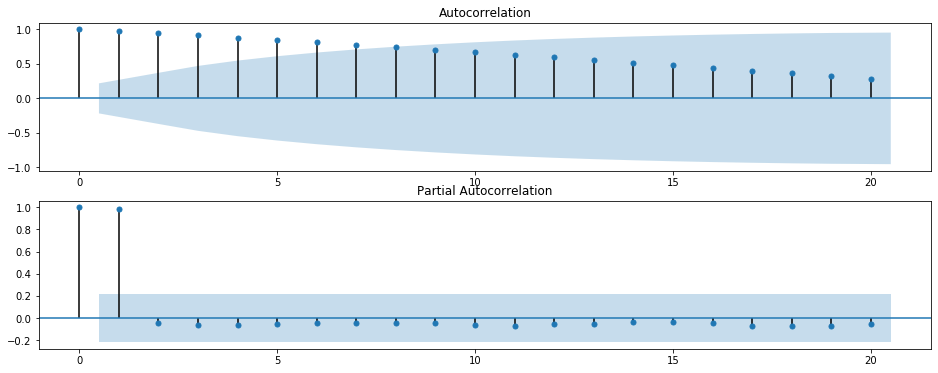

ARIMA(0, 0, 1) RMSE=31540.806
ARIMA(0, 1, 1) RMSE=1339.663
ARIMA(0, 2, 1) RMSE=710.135
ARIMA(0, 2, 2) RMSE=802.651
ARIMA(1, 0, 0) RMSE=2033.221
ARIMA(1, 1, 0) RMSE=689.679
ARIMA(1, 2, 0) RMSE=720.999
ARIMA(1, 2, 1) RMSE=744.340
ARIMA(2, 1, 0) RMSE=718.735
ARIMA(2, 2, 0) RMSE=863.529
Best ARIMA(1, 1, 0) RMSE=689.679
RMSE: 689.679
                 0
count    41.000000
mean     75.497052
std     694.050654
min   -1910.415504
25%    -310.970898
50%      14.097912
75%     352.905977
max    2117.744661


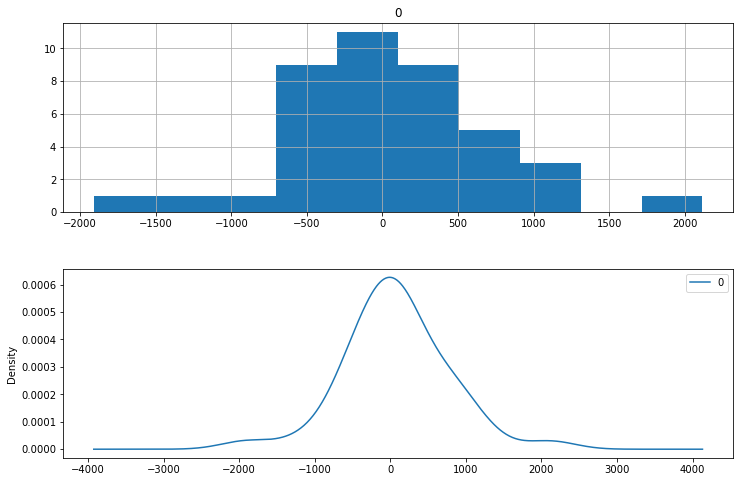


bias saved in arg_dict["bias"] for subsequent run is: 75.49705165710164 

RMSE: 685.534
                  0
count  4.100000e+01
mean  -2.395742e-12
std    6.940507e+02
min   -1.985913e+03
25%   -3.864679e+02
50%   -6.139914e+01
75%    2.774089e+02
max    2.042248e+03


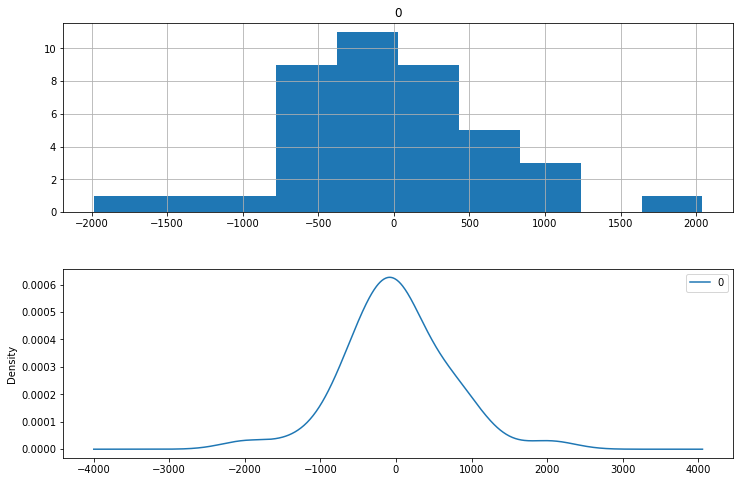


bias saved in arg_dict["bias"] for subsequent run is: -2.3957421412555184e-12 



In [4]:
# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save df and arg_dict for subsequent independent processing
df.to_csv('df.csv')
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'bias': bias})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rerun summarize, as bias adjusted
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 91,157


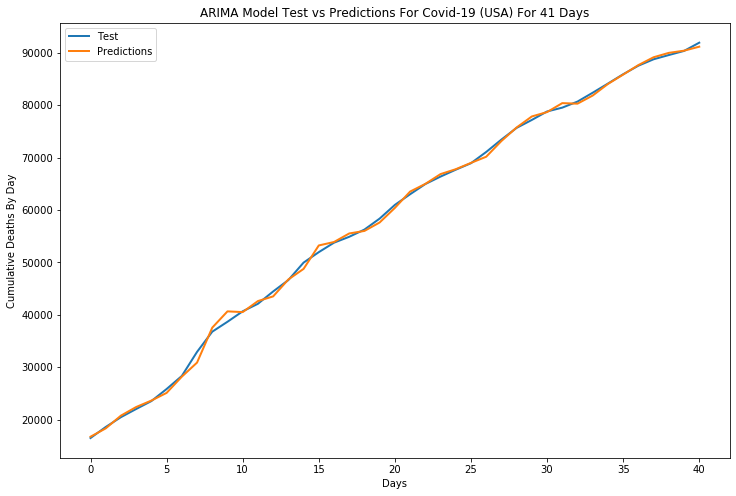

In [5]:
# Plot, save, and forecast
tpsf1.driver(arg_dict)

The USA prediction is for 1,537,851 cumulative Deaths to occur by 2020-12-31


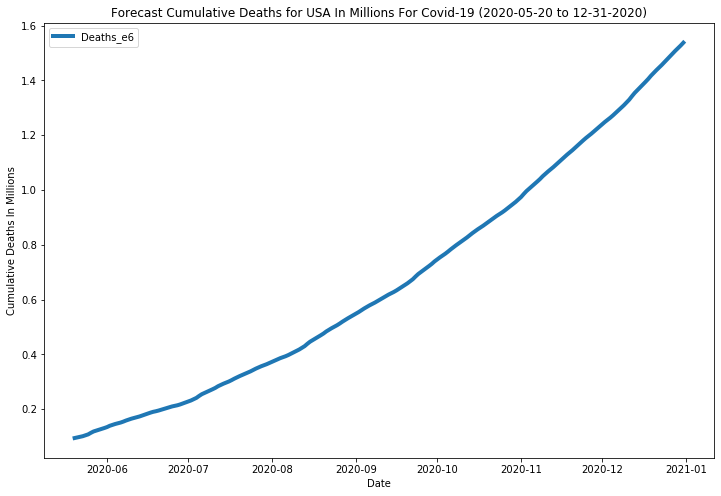

In [6]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

In [7]:
# Look at the last 5 days of the actual data
new_col_name = 'Daily_' + arg_dict["dependent_variable"]
df[new_col_name] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift(1)
df.tail()

,Deaths,Daily_Deaths
Date_,,
2020-05-15,87530.0,1632.0
2020-05-16,88754.0,1224.0
2020-05-17,89562.0,808.0
2020-05-18,90347.0,785.0
2020-05-19,91921.0,1574.0


In [8]:
# First 5 days of forecasted data
forecast_df.head()

,Deaths,Deaths_e6
2020-05-20,94150.0,0.094150
2020-05-21,96409.0,0.096409
2020-05-22,98558.0,0.098558
2020-05-23,100823.0,0.100823
2020-05-24,104013.0,0.104013
